<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">BE - ML</div>

# Introduction

Le BE-ML consiste en l'analyse du dataset ...

# partie Colin

[1.         0.99518845 0.99759423 0.99919808 1.        ]


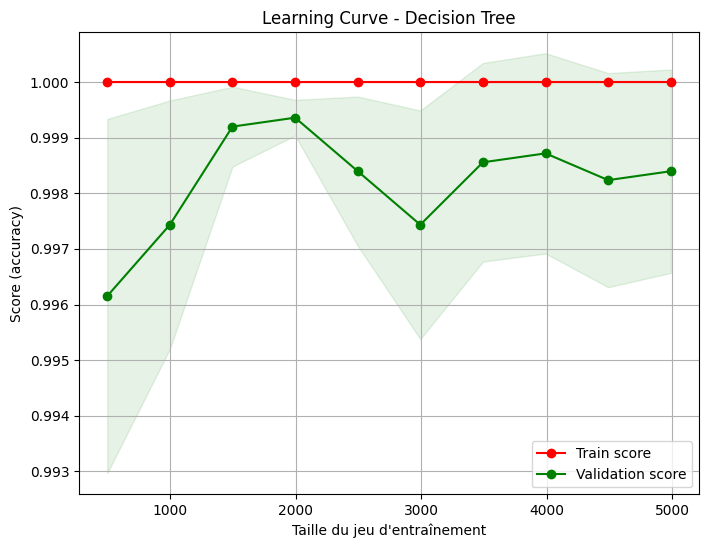

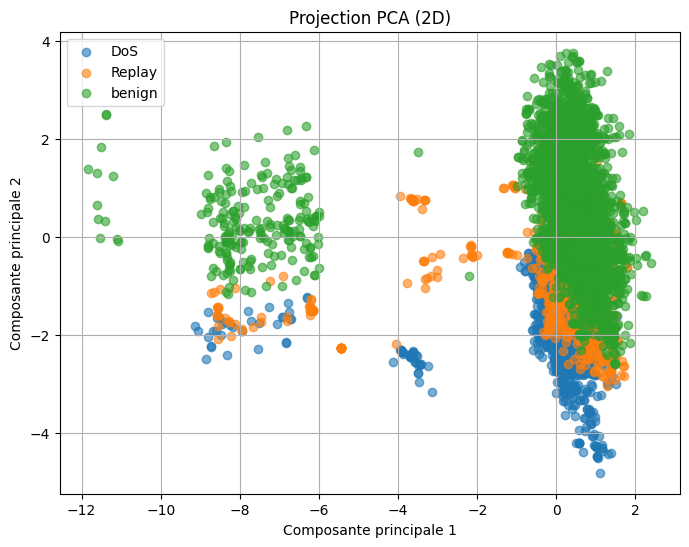

Variance expliquée par composante : [0.21937489 0.12786732]


In [1]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import learning_curve

# === Chargement des données ===
data_Physical = pd.read_csv('Data/Merged_Physical.csv')
X_physical = data_Physical.drop(columns=['class'])
y_physical = data_Physical['class']

data_Cyber = pd.read_csv('Data/Merged_Cyber.csv')
X_cyber = data_Cyber.drop(columns=['class'])
y_cyber = data_Cyber['class']

# === Choisir le dataset à utiliser ===
X = X_physical
y = y_physical
# X = X_cyber
# y = y_cyber

# === 0. Mélange aléatoire (shuffle) ===
X, y = shuffle(X, y, random_state=42)

# === 1. Pipeline : normalisation + modèle === Découpage K-Fold train/test
model = make_pipeline(StandardScaler(), DecisionTreeClassifier(criterion = 'entropy'))

# === 2. Découpage train/test : méthode K-Fold ===
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

# === 4. Évaluation ===
scores = cross_val_score(model, X, y, cv=kf5)
print(scores)

# === 3️⃣ Calculer les learning curves ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    cv=kf5,                  # 5-fold cross-validation
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 points de 10% à 100% des données
    scoring='accuracy',
    random_state=42
)

# === 4️⃣ Calculer les moyennes et écarts-types ===
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# === 5️⃣ Tracer les courbes ===
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Train score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation score")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, color="g", alpha=0.1)

plt.title("Learning Curve - Decision Tree")
plt.xlabel("Taille du jeu d'entraînement")
plt.ylabel("Score (accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


# === Standardiser les données ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# === Appliquer la PCA ===
pca = PCA(n_components=2)   # On garde 2 composantes pour visualiser
X_pca = pca.fit_transform(X_scaled)
# === Visualisation ===
labels = np.unique(y)
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    plt.scatter(X_pca[y==label, 0], X_pca[y==label, 1], label=label, alpha=0.6)

plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Projection PCA (2D)')
plt.legend()
plt.grid(True)
plt.show()

print("Variance expliquée par composante :", pca.explained_variance_ratio_)


Méthode XGBoost 

Scores: [1.         0.99839615 0.99919808 0.99839615 1.        ]
Mean: 0.9991980753809141
Standard Deviation: 0.0007172631844425825


<Axes: xlabel='Feature'>

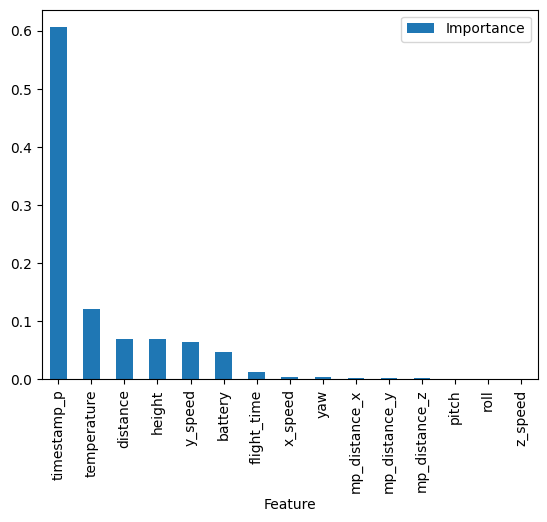

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

xgb = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb, X, y_encoded, cv=kf5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())


X.drop(columns=['barometer'], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2. Découpage train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
xgb.fit(X_train, y_train)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')

importances.plot.bar()

# partie Mohamed

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # nécessaire pour le tracé 3D
import os
import plotly.graph_objects as go
import plotly.express as px
import glob

In [14]:
# === CONFIGURATION ===
csv_path = "Dataset_T-ITS.csv"     # ton fichier d’origine
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)

# === Définition des plages (1-based, inclusives) ===
ranges = {
    "Benign":       {"Cyber": (1, 9426),     "Physical": (9427, 13717)},
    "DoS Attack":   {"Cyber": (13718, 25389),"Physical": (25390, 26363)},
    "Replay Attack":{"Cyber": (26364, 38370),"Physical": (38371, 39344)},
    "Evil Twin":    {"Cyber": (39345, 45028),"Physical": (45029, 50502)},
    "FDI":          {"Cyber": (50503, 53976),"Physical": (53977, 54784)}
}

# === LECTURE SANS HEADER ===
df_raw = pd.read_csv(csv_path, header=None)
n = len(df_raw)
print(f"📂 Fichier chargé ({n} lignes)\n")

# === FONCTION DE DÉTECTION D’EN-TÊTE PAR MOT-CLÉ ===
def is_header_line(row):
    return row.astype(str).str.contains("class", case=False, na=False).any()

# === EXTRACTION DES BLOCS SELON LES RANGES ===
for attack, parts in ranges.items():
    for part_name, (start, end) in parts.items():
        start_idx = max(0, start - 1)
        end_idx = min(n, end)
        sub_df = df_raw.iloc[start_idx:end_idx].copy()

        # Trouver la ligne d'en-tête à l'intérieur du bloc
        header_idx = sub_df.index[sub_df.apply(is_header_line, axis=1)]
        if len(header_idx) == 0:
            print(f"⚠️ Aucun header trouvé dans {attack} - {part_name} ({start}-{end}), ignoré.")
            continue

        header_row = header_idx[0]
        header = sub_df.loc[header_row]

        # Supprimer les lignes avant le header
        sub_df = sub_df.loc[header_row + 1:]
        sub_df.columns = header
        sub_df.reset_index(drop=True, inplace=True)

        # === 🔹 NETTOYAGE DES COLONNES VIDES ===
        # Supprimer colonnes entièrement vides
        sub_df = sub_df.dropna(axis=1, how='all')

        # Supprimer colonnes avec nom vide ou indéfini
        sub_df = sub_df.loc[:, [str(c).strip() not in ["", "Unnamed: 0", "Unnamed: 1", "nan"] for c in sub_df.columns]]

        # Supprimer colonnes où toutes les valeurs sont NaN ou juste des virgules vides
        sub_df = sub_df.loc[:, sub_df.apply(lambda col: not all(str(x).strip() in ["", "nan"] for x in col), axis=0)]

        # Calcul du nombre de features
        valid_features = [c for c in sub_df.columns if pd.notna(c) and str(c).strip() != ""]
        n_features = len(valid_features)

        # Sauvegarde
        filename = f"{attack.replace(' ', '_')}_{part_name}.csv"
        path_out = os.path.join(output_dir, filename)
        sub_df.to_csv(path_out, index=False)

        # Affichage final
        print(f"✅ {attack} ({part_name}) : {len(sub_df)} lignes, {n_features} features")

print("\n🎯 Terminé : tous les blocs ont été extraits et nettoyés.")


/tmp/ipykernel_31497/1210916175.py:16: DtypeWarning: Columns (35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(csv_path, header=None)


📂 Fichier chargé (54784 lignes)

✅ Benign (Cyber) : 9425 lignes, 38 features
✅ Benign (Physical) : 4290 lignes, 17 features
✅ DoS Attack (Cyber) : 11671 lignes, 38 features
✅ DoS Attack (Physical) : 973 lignes, 17 features
✅ Replay Attack (Cyber) : 12006 lignes, 38 features
✅ Replay Attack (Physical) : 973 lignes, 17 features
✅ Evil Twin (Cyber) : 5683 lignes, 35 features
✅ Evil Twin (Physical) : 5473 lignes, 22 features
✅ FDI (Cyber) : 3473 lignes, 35 features
✅ FDI (Physical) : 807 lignes, 32 features

🎯 Terminé : tous les blocs ont été extraits et nettoyés.


In [15]:
data_Begnin_Cyber = pd.read_csv('Data/Benign_Cyber.csv')
data_Begnin_Physical = pd.read_csv('Data/Benign_Physical.csv')
data_DoS_Cyber = pd.read_csv('Data/DoS_Attack_Cyber.csv')
data_DoS_Physical = pd.read_csv('Data/DoS_Attack_Physical.csv')
data_Replay_Cyber = pd.read_csv('Data/Replay_Attack_Cyber.csv')
data_Replay_Physical = pd.read_csv('Data/Replay_Attack_Physical.csv')
data_EvilTwin_Cyber = pd.read_csv('Data/Evil_Twin_Cyber.csv')
data_EvilTwin_Physical = pd.read_csv('Data/Evil_Twin_Physical.csv')
data_FDI_Cyber = pd.read_csv('Data/FDI_Cyber.csv')
data_FDI_Physical = pd.read_csv('Data/FDI_Physical.csv')

In [18]:
data_Begnin_Physical.head()

,timestamp_p,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z,class
0,28123.02875,80,0,0,0,0,0,0,68,84,19309,7,65,-15,-5,86,benign
1,28123.55962,80,0,0,0,0,0,0,68,84,19305,7,65,-13,-6,86,benign
2,28124.07690,80,0,0,0,0,0,0,68,83,19303,8,65,-18,-6,85,benign
3,28124.60200,80,0,0,0,-1,0,0,67,83,19307,8,65,-21,-9,84,benign
4,28125.12910,80,0,0,0,-1,0,0,67,85,19309,9,65,-24,-10,84,benign


In [19]:
data_Begnin_Physical.describe()

,timestamp_p,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z
count,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000
mean,38373.622706,71.979021,0.067599,-0.087879,0.103263,-0.546387,-0.241026,55.676923,67.177389,97.350583,20610.464103,39.074592,59.656177,-12.591142,-14.066200,67.952681
std,6880.388077,13.429245,1.315332,0.450349,0.627581,1.660456,0.776307,90.928146,2.791420,342.113961,710.914790,19.965639,23.996521,47.516717,45.159429,62.623750
min,28123.028750,-10.000000,-5.000000,-3.000000,-2.000000,-11.000000,-7.000000,-179.000000,53.000000,10.000000,18909.000000,2.000000,20.000000,-200.000000,-200.000000,-200.000000
25%,31300.990075,70.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,66.000000,79.000000,19817.000000,22.000000,40.000000,-12.000000,-14.000000,80.000000
50%,38485.998845,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000,80.000000,21025.000000,38.000000,61.000000,-4.000000,-5.000000,82.000000
75%,43875.459452,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.000000,69.000000,82.000000,21231.000000,55.000000,79.000000,4.000000,4.000000,84.000000
max,54385.241520,110.000000,5.000000,3.000000,4.000000,8.000000,6.000000,179.000000,74.000000,6553.000000,21356.000000,95.000000,100.000000,68.000000,49.000000,122.000000


In [46]:
import plotly.graph_objects as go

def plot_3d_flight_path_animated(df, title="Animation 3D — Trajectoire dans le temps", frame_duration=400):
    """
    Crée une animation 3D de la trajectoire (mp_distance_x, mp_distance_y, mp_distance_z)
    évoluant dans le temps selon 'timestamp_p', sans température.
    
    Paramètres :
        df : DataFrame contenant les colonnes ['timestamp_p','mp_distance_x','mp_distance_y','mp_distance_z']
        title : titre du graphique
        frame_duration : durée (ms) de chaque frame — plus grand = animation plus lente
    """

    required_cols = ["timestamp_p", "mp_distance_x", "mp_distance_y", "mp_distance_z"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"❌ Colonne manquante : {col}")

    df_sorted = df.sort_values("timestamp_p").reset_index(drop=True)
    n_frames = min(100, len(df_sorted))
    step = max(1, len(df_sorted) // n_frames)

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=[df_sorted["mp_distance_x"].iloc[0]],
                y=[df_sorted["mp_distance_y"].iloc[0]],
                z=[df_sorted["mp_distance_z"].iloc[0]],
                mode="lines+markers",
                line=dict(color="blue", width=4),
                marker=dict(size=4, color="blue"),
                name="Trajectoire"
            )
        ],
        layout=go.Layout(
            title=title,
            scene=dict(
                xaxis_title="mp_distance_x",
                yaxis_title="mp_distance_y",
                zaxis_title="mp_distance_z",
                aspectmode="cube"
            ),
            template="plotly_white",
            width=950,
            height=800,
            updatemenus=[{
                "buttons": [
                    {
                        # ⏬ vitesse ajustée ici
                        "args": [None, {"frame": {"duration": frame_duration, "redraw": True},
                                        "fromcurrent": True, "mode": "immediate"}],
                        "label": "▶️ Play",
                        "method": "animate"
                    },
                    {
                        "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                          "mode": "immediate"}],
                        "label": "⏸️ Pause",
                        "method": "animate"
                    }
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 85},
                "showactive": False,
                "type": "buttons",
                "x": 0.1,
                "xanchor": "right",
                "y": 0,
                "yanchor": "top"
            }]
        ),
        frames=[
            go.Frame(
                data=[
                    go.Scatter3d(
                        x=df_sorted["mp_distance_x"].iloc[:k],
                        y=df_sorted["mp_distance_y"].iloc[:k],
                        z=df_sorted["mp_distance_z"].iloc[:k],
                        mode="lines+markers",
                        line=dict(color="blue", width=4),
                        marker=dict(size=3, color="blue")
                    )
                ],
                name=f"Frame {k}",
                traces=[0],
                layout=go.Layout(
                    title=f"{title} — t = {df_sorted['timestamp_p'].iloc[k]}"
                )
            )
            for k in range(1, len(df_sorted), step)
        ]
    )

    fig.show()


In [47]:
plot_3d_flight_path_animated(
    data_Begnin_Physical, 
    title="Animation 3D — Données physiques bénignes"
)

plot_3d_flight_path_animated(
    data_DoS_Physical, 
    title="Animation 3D — Données physiques DoS Attack"
)
plot_3d_flight_path_animated(
    data_Replay_Physical, 
    title="Animation 3D — Données physiques Replay Attack"
)

In [48]:
def plot_flight_distance_temperature_continuous(df, title="Courbe continue — timestamp_p vs mp_distance_z"):
    """
    Trace une ligne continue avec des points colorés par température.
    """
    required_cols = ["timestamp_p", "mp_distance_z", "temperature"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"❌ Colonne manquante dans le DataFrame : {col}")

    df_sorted = df.sort_values(by="timestamp_p")

    fig = go.Figure()

    # Ligne grise en arrière-plan
    fig.add_trace(go.Scatter(
        x=df_sorted["timestamp_p"],
        y=df_sorted["mp_distance_z"],
        mode="lines",
        line=dict(color="lightgray", width=1.5),
        name="Trajectoire"
    ))

    # Points colorés par température
    fig.add_trace(go.Scatter(
        x=df_sorted["timestamp_p"],
        y=df_sorted["mp_distance_z"],
        mode="markers",
        marker=dict(
            color=df_sorted["temperature"],
            colorscale="Plasma",
            size=6,
            colorbar=dict(title="Température"),
            showscale=True
        ),
        name="Température"
    ))

    fig.update_layout(
        title=title,
        xaxis_title="timestamp_p",
        yaxis_title="mp_distance_z",
        template="plotly_white",
        width=950,
        height=700
    )

    fig.show()



# Exemple d'utilisation :
plot_flight_distance_temperature_continuous(data_Begnin_Physical, 
    title="Courbe continue — Données physiques bénignes")
plot_flight_distance_temperature_continuous(data_DoS_Physical, 
    title="Courbe continue — Données physiques DoS Attack")
plot_flight_distance_temperature_continuous(data_Replay_Physical, 
    title="Courbe continue — Données physiques Replay Attack")


### Physical Data 

In [50]:
# === CONFIGURATION ===
# Chemin vers le dossier contenant les fichiers physiques
input_dir = "Data"       # dossier où tu as sauvegardé les CSV
output_file = "Data/Merged_Physical.csv"

# Liste précise des fichiers à fusionner
files_to_merge = [
    os.path.join(input_dir, "Benign_Physical.csv"),
    os.path.join(input_dir, "DoS_Attack_Physical.csv"),
    os.path.join(input_dir, "Replay_Attack_Physical.csv")
]

# === Vérification existence ===
for f in files_to_merge:
    if not os.path.exists(f):
        raise FileNotFoundError(f"❌ Fichier introuvable : {f}")

# === Lecture et nettoyage ===
dfs = []
for i, f in enumerate(files_to_merge):
    df = pd.read_csv(f)
    
    # Supprimer toute ligne contenant "class" ou "timestamp" dans la première colonne (résidus d'en-têtes)
    df = df[~df.iloc[:, 0].astype(str).str.contains("class|timestamp", case=False, na=False)]
    
    # Garder l'en-tête uniquement pour le premier fichier
    if i == 0:
        dfs.append(df)
    else:
        # Vérifier cohérence colonnes
        df.columns = dfs[0].columns
        dfs.append(df)

# === Fusion verticale ===
merged_df = pd.concat(dfs, ignore_index=True)

# === Nettoyage final ===
merged_df = merged_df.dropna(how="all")  # supprimer lignes vides
merged_df.reset_index(drop=True, inplace=True)

# === Sauvegarde ===
merged_df.to_csv(output_file, index=False)
print(f"✅ Fichiers fusionnés -> {output_file}")
print(f"Total : {len(merged_df)} lignes, {len(merged_df.columns)} colonnes")


✅ Fichiers fusionnés -> Data/Merged_Physical.csv
Total : 6236 lignes, 17 colonnes


###  Cyber Data 

In [52]:
import pandas as pd
import os

# === CONFIGURATION ===
input_dir = "Data"          # dossier où se trouvent tes fichiers .csv
output_file = "Data/Merged_Cyber.csv"

# === Fichiers à fusionner ===
files_to_merge = [
    os.path.join(input_dir, "Benign_Cyber.csv"),
    os.path.join(input_dir, "DoS_Attack_Cyber.csv"),
    os.path.join(input_dir, "Replay_Attack_Cyber.csv")
]

# === Vérification existence ===
for f in files_to_merge:
    if not os.path.exists(f):
        raise FileNotFoundError(f"❌ Fichier introuvable : {f}")

# === Lecture + Nettoyage ===
dfs = []
for i, f in enumerate(files_to_merge):
    df = pd.read_csv(f)
    
    # Supprimer toute ligne contenant "class" ou "timestamp" dans la première colonne (cas d'en-tête répété)
    df = df[~df.iloc[:, 0].astype(str).str.contains("class|timestamp", case=False, na=False)]
    
    # Harmoniser les colonnes avec le premier fichier
    if i == 0:
        dfs.append(df)
    else:
        df.columns = dfs[0].columns  # Assure la même structure
        dfs.append(df)

# === Fusionner verticalement ===
merged_df = pd.concat(dfs, ignore_index=True)
merged_df = merged_df.dropna(how="all")   # Supprime lignes vides
merged_df.reset_index(drop=True, inplace=True)

# === Sauvegarde ===
merged_df.to_csv(output_file, index=False)
print(f"✅ Fichiers fusionnés -> {output_file}")
print(f"Total : {len(merged_df)} lignes, {len(merged_df.columns)} colonnes")


✅ Fichiers fusionnés -> Data/Merged_Cyber.csv
Total : 33102 lignes, 38 colonnes


### Classification


=== 🧠 Rapport de classification ===
              precision    recall  f1-score   support

  DoS attack       0.96      0.82      0.88      3501
      Replay       0.84      0.90      0.87      3602
      benign       0.92      0.99      0.95      2828

    accuracy                           0.90      9931
   macro avg       0.90      0.90      0.90      9931
weighted avg       0.90      0.90      0.90      9931


=== 📊 Matrice de confusion ===
[[2872  596   33]
 [ 129 3249  224]
 [   6   15 2807]]


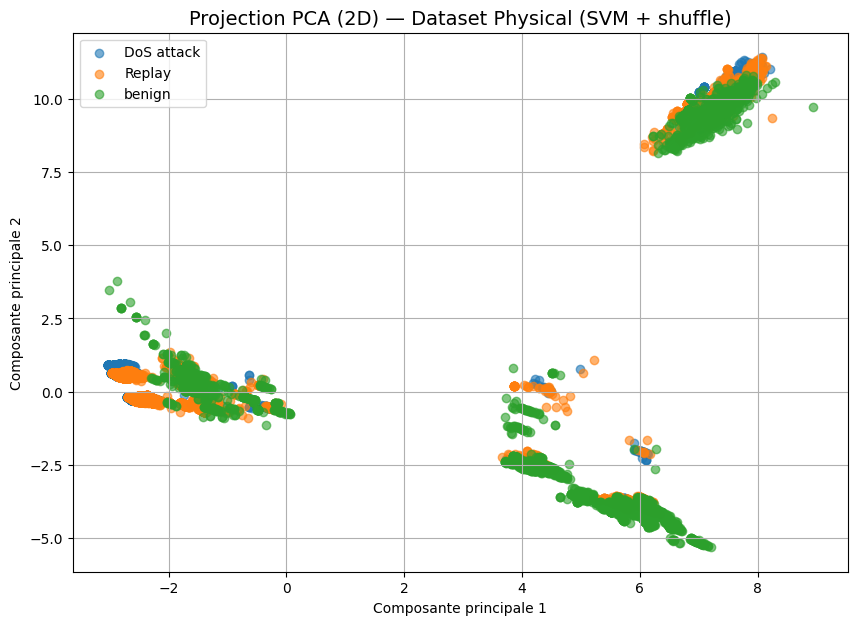

In [58]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# === Chargement des données ===
data_Physical = pd.read_csv('Data/Merged_Physical.csv')
X_physical = data_Physical.drop(columns=['class'])
y_physical = data_Physical['class']

data_Cyber = pd.read_csv('Data/Merged_Cyber.csv')
X_cyber = data_Cyber.drop(columns=['class'])
y_cyber = data_Cyber['class']

# === Choisir le dataset à utiliser ===
# X = X_physical
# y = y_physical
X = X_cyber
y = y_cyber

# === 0. Mélange aléatoire (shuffle) ===
X, y = shuffle(X, y, random_state=42)

# === 1. Normalisation ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2. Découpage train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# === 3. Entraînement du SVM ===
svm = SVC(kernel='rbf', gamma='scale')
svm.fit(X_train, y_train)

# === 4. Évaluation ===
y_pred = svm.predict(X_test)
print("\n=== 🧠 Rapport de classification ===")
print(classification_report(y_test, y_pred))
print("\n=== 📊 Matrice de confusion ===")
print(confusion_matrix(y_test, y_pred))

# === 5. Réduction de dimension (PCA à 2 composantes) ===
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X_scaled)

# === 6. Visualisation ===
plt.figure(figsize=(10, 7))
classes = np.unique(y)

for c in classes:
    plt.scatter(X_pca[y == c, 0], X_pca[y == c, 1], label=c, alpha=0.6)

plt.title("Projection PCA (2D) — Dataset Physical (SVM + shuffle)", fontsize=14)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.show()
